In [13]:
import psycopg2
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ============================
# 1. Caricamento dei dati
# ============================
host = "localhost"
port = "5432"
dbname = "DataScience"
user = "postgres"
password = "2430"

conn = psycopg2.connect(host=host, port=port, dbname=dbname, user=user, password=password)
query = "SELECT * FROM public.vew_mts_prov"
df = pd.read_sql_query(query, conn)
conn.close()

print("Dati caricati:")
print(df.head())

Dati caricati:
  provincia      giorno  total_transiti  total_trleggeri  total_trpesanti  \
0        BO  2019-01-01          266060           264766             1287   
1        PR  2019-01-01          132856           131849             1003   
2        PC  2019-01-01          158867           158177              688   
3        RN  2019-01-01          127765           127097              666   
4        RA  2019-01-01          108226           107727              499   

   total_trnonclassificati  total_trdiurno  total_trnotturno  total_trferiali  \
0                       70          161082            104978                0   
1                       40           79581             53275                0   
2                       20           99417             59450                0   
3                       20           76676             51089                0   
4                        0           66930             41296                0   

   total_trfestivi  ngiornosettiman

C:\Users\matte\AppData\Local\Temp\ipykernel_1568\1071397384.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [14]:
# ================================
# 2. Preprocessing e Feature Engineering
# ================================
# Converti 'giorno' in datetime e ordina per provincia e giorno
df['giorno'] = pd.to_datetime(df['giorno'])
df = df.sort_values(['provincia', 'giorno']).reset_index(drop=True)

# Crea feature temporali: giorno della settimana e mese
df['giorno_della_settimana'] = df['giorno'].dt.weekday
df['mese'] = df['giorno'].dt.month

# Crea lag features (dal lag_1 al lag_7) per ciascuna provincia
for lag in range(1, 8):
    df[f'lag_{lag}'] = df.groupby('provincia')['total_transiti'].shift(lag)

# Definisci il target come il traffico totale
df['target'] = df['total_transiti']

# Per la valutazione, conserva il nome originale della provincia
df['provincia_orig'] = df['provincia']

# Rimuovi le righe con NaN (causati dai lag)
df = df.dropna().reset_index(drop=True)

# Applica il One-Hot Encoding sulla variabile 'provincia'
df = pd.get_dummies(df, columns=['provincia'], prefix='provincia')

# Definisci le feature: lag features, feature temporali e colonne one-hot per provincia
lag_features = [f'lag_{i}' for i in range(1, 8)]
temporal_features = ['giorno_della_settimana', 'mese']
# Escludi eventuale colonna 'provincia_orig' dalle feature numeriche
provincia_columns = [col for col in df.columns if col.startswith('provincia_') and col != 'provincia_orig']
feature_columns = lag_features + temporal_features + provincia_columns

X = df[feature_columns]
y = df['target']

In [15]:
# ================================
# 3. Suddivisione in Train e Test (time-aware) per provincia
# ================================
# Per assicurare che il test set contenga dati di tutte le province, eseguiamo lo split per ciascuna provincia.
train_dfs = []
test_dfs = []

for prov in df['provincia_orig'].unique():
    df_prov = df[df['provincia_orig'] == prov].copy().sort_values('giorno')
    split_idx = int(len(df_prov) * 0.8)
    train_dfs.append(df_prov.iloc[:split_idx])
    test_dfs.append(df_prov.iloc[split_idx:])

train_df = pd.concat(train_dfs).sort_index()
test_df = pd.concat(test_dfs).sort_index()

X_train = train_df[feature_columns]
y_train = train_df['target']
dates_train = train_df['giorno']
province_train = train_df['provincia_orig']

X_test = test_df[feature_columns]
y_test = test_df['target']
dates_test = test_df['giorno']
province_test = test_df['provincia_orig']

print("Province nel test set:", province_test.unique())

Province nel test set: ['BO' 'FC' 'FE' 'MO' 'PC' 'PR' 'RA' 'RE' 'RN']


In [17]:
# ================================
# 4. Scaling delle Feature e del Target
# ================================
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()


MAE complessivo sul test set: 17573.726812817615
MAE per provincia:
provincia
BO    31118.419963
FC    12366.648213
FE     4725.310059
MO    18804.273676
PC    21207.594959
PR    21028.816553
RA    10558.899723
RE    28216.927714
RN    10136.650454
dtype: float64


C:\Users\matte\AppData\Local\Temp\ipykernel_1568\1425047662.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_per_provincia = results_test.groupby('provincia').apply(


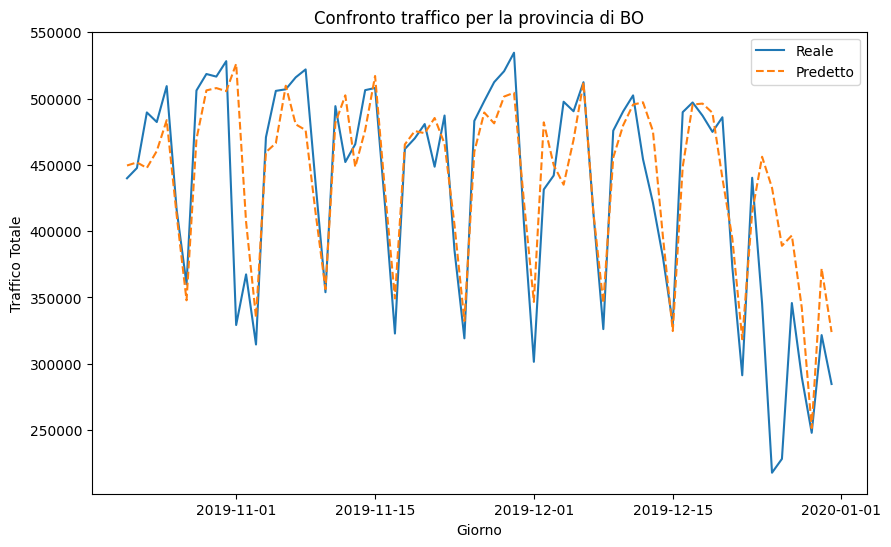

In [18]:
# ================================
# 5. Allenamento del Modello
# ================================
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train_scaled, y_train_scaled)

# Previsioni sul set di test
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

# Calcola il MAE complessivo
mae_overall = mean_absolute_error(y_test, y_pred)
print(f'MAE complessivo sul test set: {mae_overall}')

# Calcola il MAE per ciascuna provincia
results_test = pd.DataFrame({
    'giorno': dates_test.values,
    'provincia': province_test.values,
    'true_traffic': y_test.values,
    'predicted_traffic': y_pred
})
mae_per_provincia = results_test.groupby('provincia').apply(
    lambda grp: mean_absolute_error(grp['true_traffic'], grp['predicted_traffic'])
)
print("MAE per provincia:")
print(mae_per_provincia)

# Visualizza un esempio di confronto per la prima provincia nell'elenco
example_prov = results_test['provincia'].unique()[0]
results_example = results_test[results_test['provincia'] == example_prov]

plt.figure(figsize=(10,6))
plt.plot(results_example['giorno'], results_example['true_traffic'], label='Reale')
plt.plot(results_example['giorno'], results_example['predicted_traffic'], label='Predetto', linestyle='--')
plt.xlabel('Giorno')
plt.ylabel('Traffico Totale')
plt.title(f'Confronto traffico per la provincia di {example_prov}')
plt.legend()
plt.show()

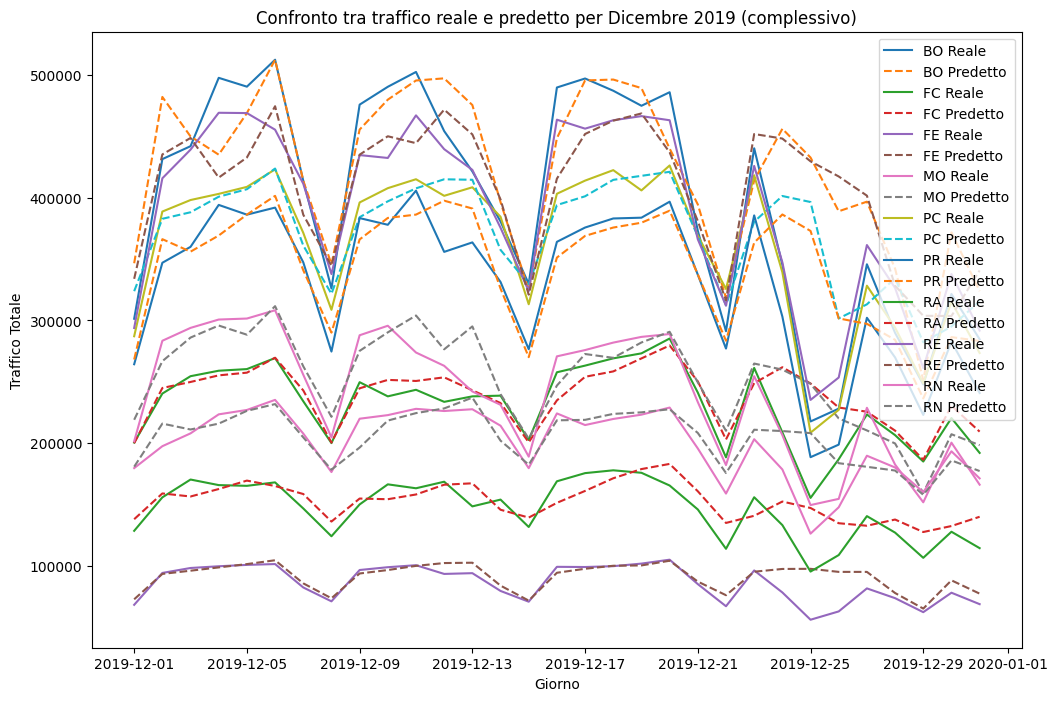

In [19]:
# ================================
# 6. Previsione del Traffico per Dicembre 2019 e confronto con i valori reali
# ================================
# Filtra il dataset per le righe di dicembre 2019
df_dec = df[(df['giorno'].dt.year == 2019) & (df['giorno'].dt.month == 12)].copy()

X_dec = df_dec[feature_columns]
y_dec = df_dec['target']
X_dec_scaled = scaler_X.transform(X_dec)
y_dec_pred_scaled = model.predict(X_dec_scaled)
y_dec_pred = scaler_y.inverse_transform(y_dec_pred_scaled.reshape(-1,1)).flatten()

# Aggiungi le previsioni al DataFrame di dicembre
df_dec['predicted_traffic'] = y_dec_pred

# Grafico complessivo: confronto per tutte le province
plt.figure(figsize=(12,8))
for prov in df_dec['provincia_orig'].unique():
    prov_df = df_dec[df_dec['provincia_orig'] == prov]
    plt.plot(prov_df['giorno'], prov_df['target'], label=f'{prov} Reale', linestyle='-')
    plt.plot(prov_df['giorno'], prov_df['predicted_traffic'], label=f'{prov} Predetto', linestyle='--')
plt.xlabel('Giorno')
plt.ylabel('Traffico Totale')
plt.title('Confronto tra traffico reale e predetto per Dicembre 2019 (complessivo)')
plt.legend()
plt.show()

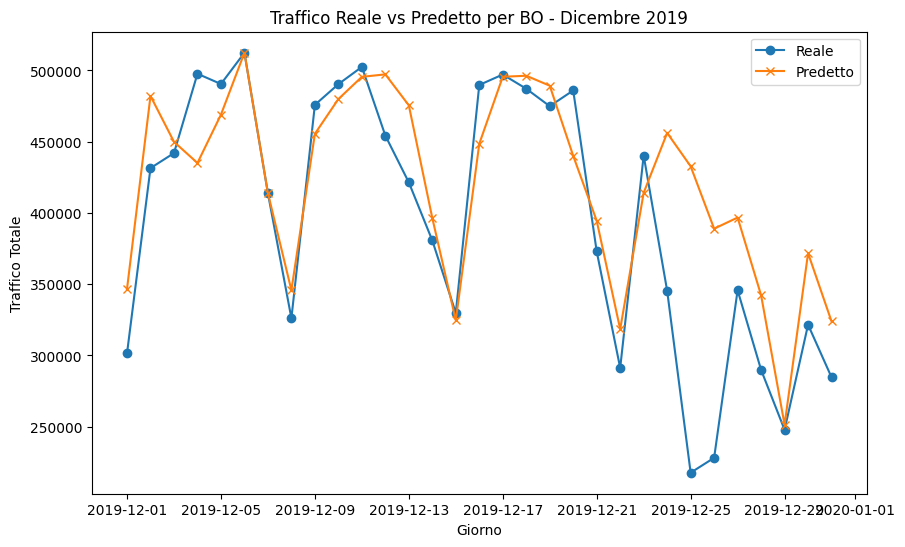

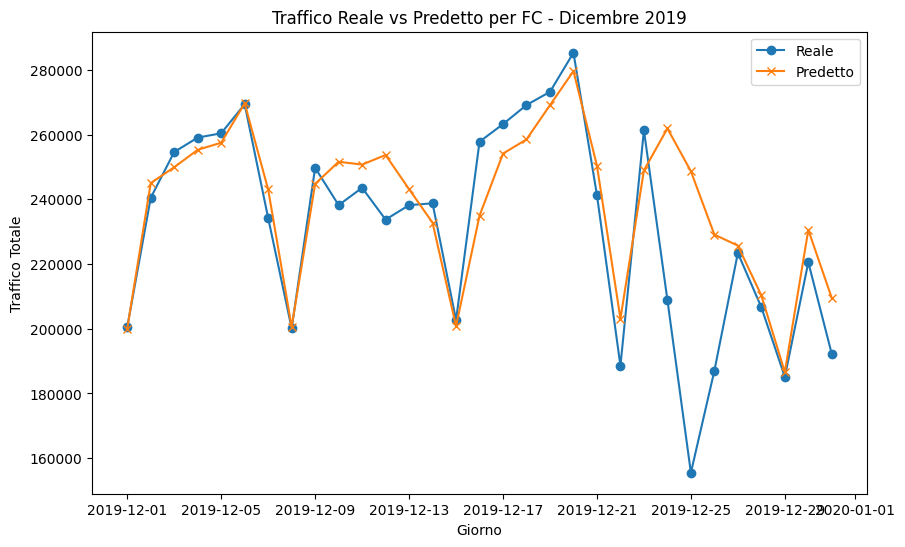

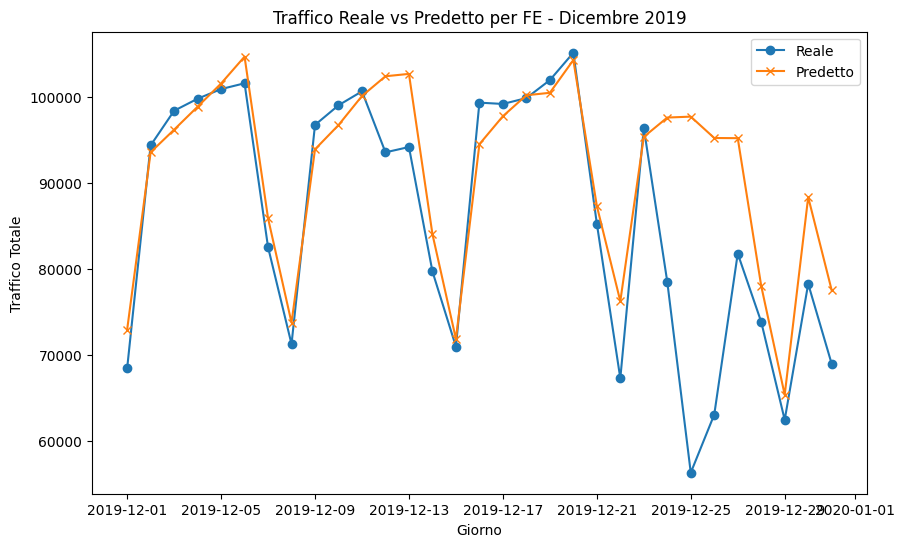

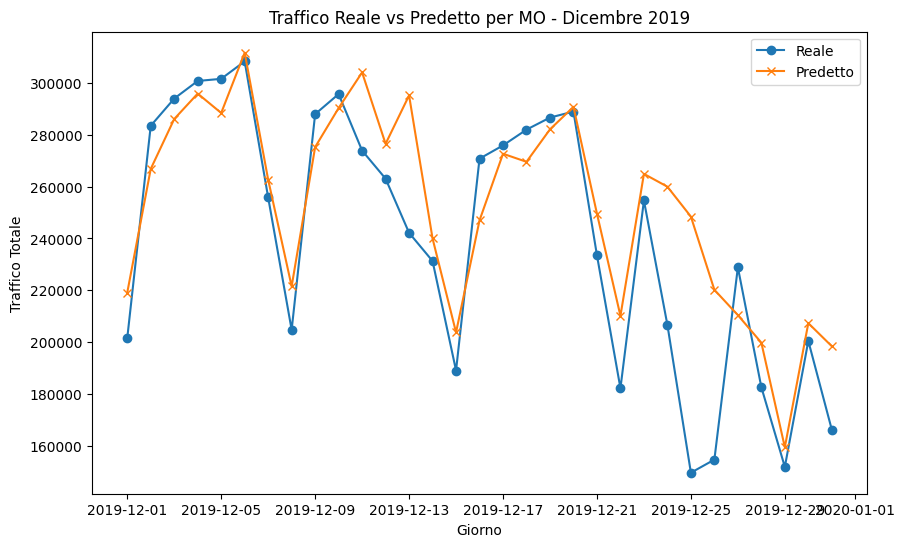

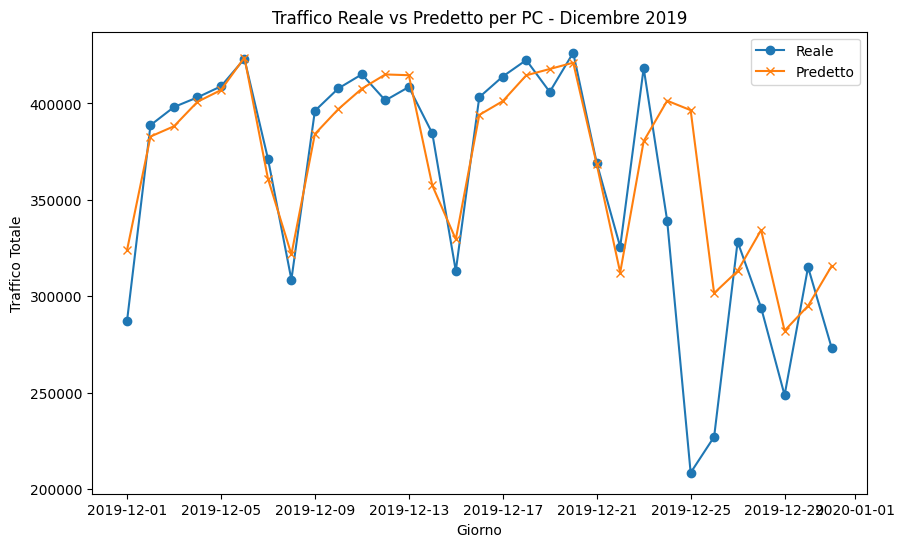

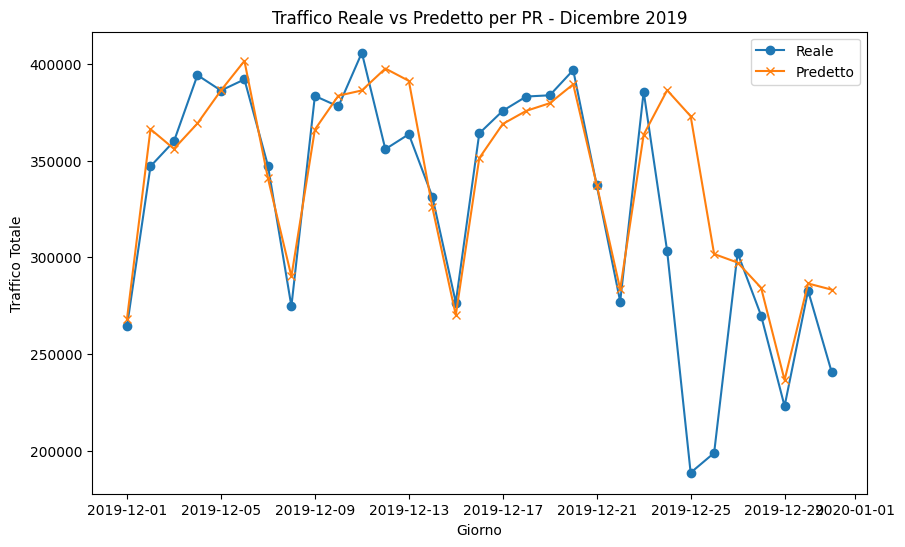

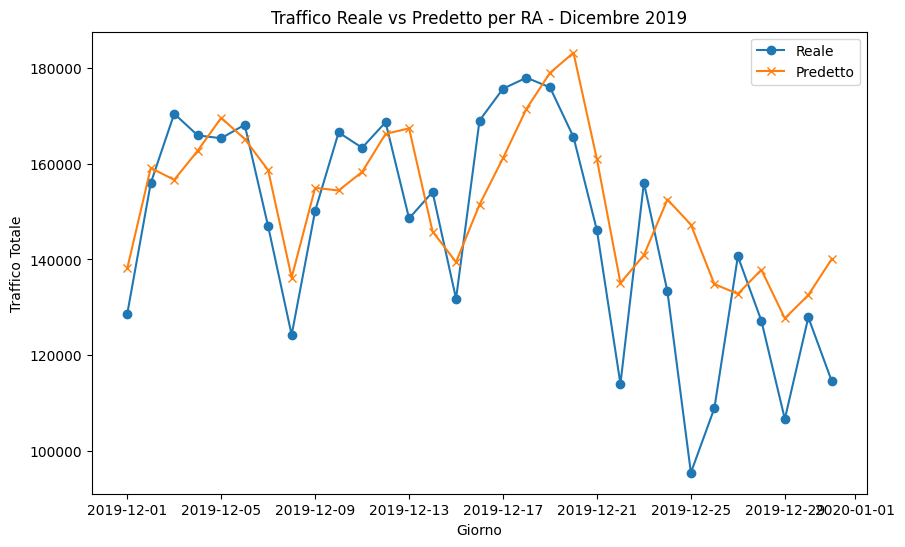

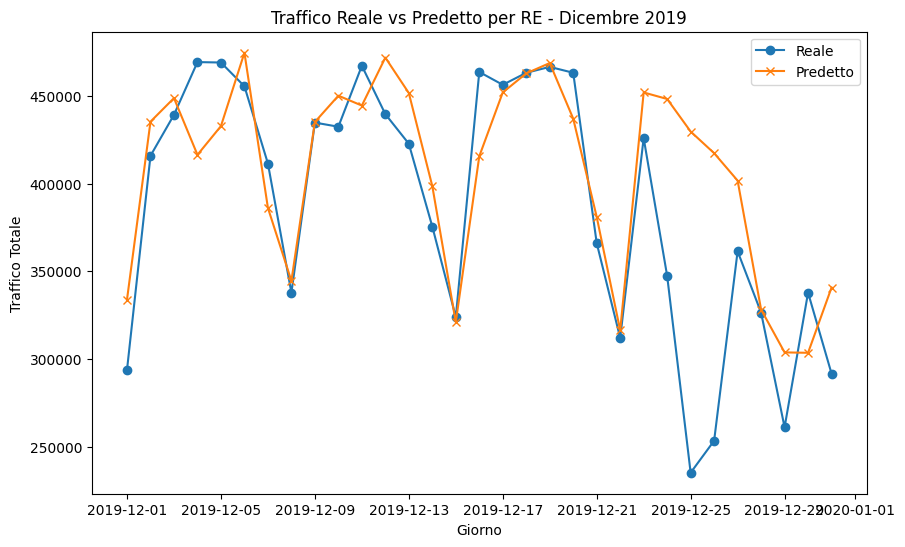

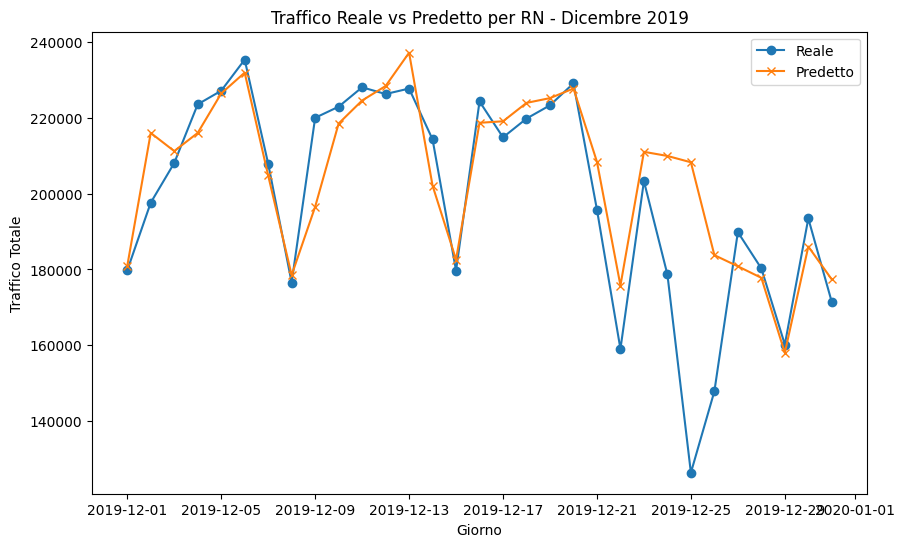

In [20]:
# ================================
# 7. Grafici individuali per Provincia in Dicembre 2019
# ================================
unique_prov_dec = df_dec['provincia_orig'].unique()
for prov in unique_prov_dec:
    df_prov_dec = df_dec[df_dec['provincia_orig'] == prov]
    plt.figure(figsize=(10,6))
    plt.plot(df_prov_dec['giorno'], df_prov_dec['target'], label='Reale', marker='o')
    plt.plot(df_prov_dec['giorno'], df_prov_dec['predicted_traffic'], label='Predetto', marker='x')
    plt.xlabel('Giorno')
    plt.ylabel('Traffico Totale')
    plt.title(f'Traffico Reale vs Predetto per {prov} - Dicembre 2019')
    plt.legend()
    plt.show()

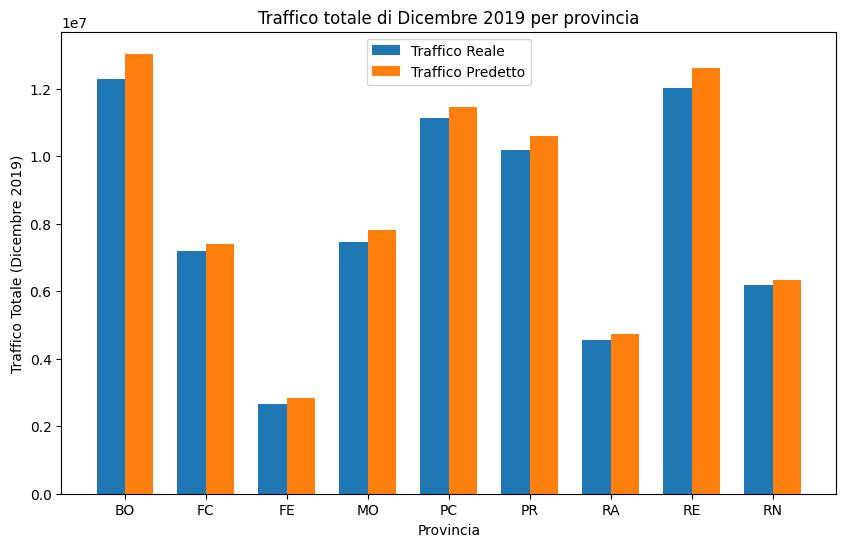

In [21]:
# ================================
# 8. Grafico a Barre per il Traffico Totale di Dicembre 2019 per Provincia
# ================================
agg_dec = df_dec.groupby('provincia_orig').agg({
    'target': 'sum',
    'predicted_traffic': 'sum'
}).reset_index()

x = np.arange(len(agg_dec))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, agg_dec['target'], width, label='Traffico Reale')
plt.bar(x + width/2, agg_dec['predicted_traffic'], width, label='Traffico Predetto')
plt.xticks(x, agg_dec['provincia_orig'])
plt.xlabel('Provincia')
plt.ylabel('Traffico Totale (Dicembre 2019)')
plt.title('Traffico totale di Dicembre 2019 per provincia')
plt.legend()
plt.show()


Confronto per giornate casuali del 2019:
         giorno provincia_orig  target  predicted_traffic
438  2019-03-29             FC  262021      262030.879176
501  2019-05-31             FC  281346      270024.784909
3060 2019-07-23             RN  208685      212650.773413
564  2019-08-02             FC  283825      287640.835380
1323 2019-09-14             MO  220914      224867.731154
631  2019-10-08             FC  275888      299618.426073
1709 2019-10-12             PC  380824      383957.796451
299  2019-11-03             BO  314487      334762.398685
1377 2019-11-07             MO  293042      284856.106708
2098 2019-11-12             PR  377829      375780.668625


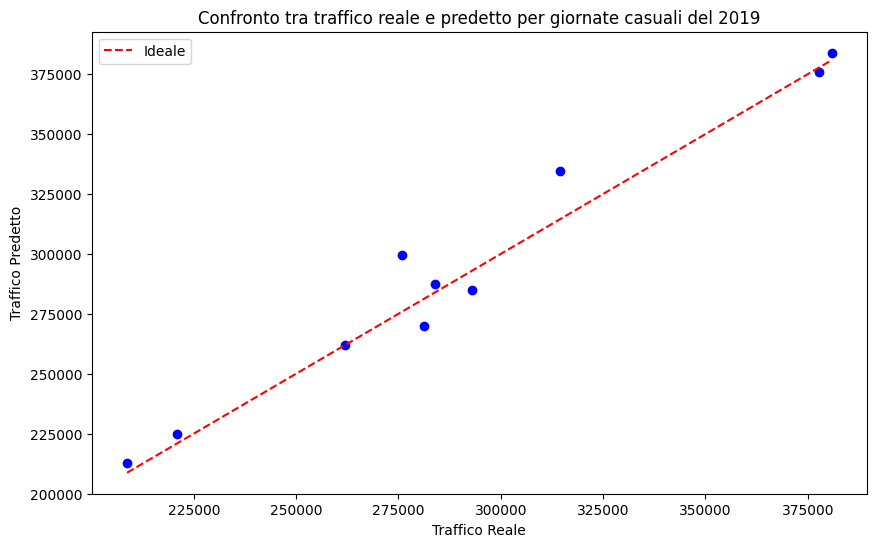

In [22]:
# ================================
# 9. Confronto per giornate casuali del 2019
# ================================
# Filtra il dataset per l'anno 2019
df_2019 = df[df['giorno'].dt.year == 2019].copy()

# Seleziona casualmente 10 righe dal 2019
random_sample = df_2019.sample(n=10, random_state=42)

# Effettua la previsione per queste righe
x_sample = random_sample[feature_columns]
x_sample_scaled = scaler_X.transform(x_sample)
y_sample_pred_scaled = model.predict(x_sample_scaled)
y_sample_pred = scaler_y.inverse_transform(y_sample_pred_scaled.reshape(-1,1)).flatten()

# Aggiungi le previsioni al DataFrame
random_sample = random_sample.copy()
random_sample['predicted_traffic'] = y_sample_pred

print("\nConfronto per giornate casuali del 2019:")
print(random_sample[['giorno', 'provincia_orig', 'target', 'predicted_traffic']].sort_values('giorno'))

plt.figure(figsize=(10,6))
plt.scatter(random_sample['target'], random_sample['predicted_traffic'], color='blue')
plt.plot([random_sample['target'].min(), random_sample['target'].max()],
         [random_sample['target'].min(), random_sample['target'].max()],
         'r--', label='Ideale')
plt.xlabel('Traffico Reale')
plt.ylabel('Traffico Predetto')
plt.title('Confronto tra traffico reale e predetto per giornate casuali del 2019')
plt.legend()
plt.show()

Feature Importances:
                   feature  importance
6                    lag_7    0.906138
0                    lag_1    0.060188
7   giorno_della_settimana    0.006898
1                    lag_2    0.006479
2                    lag_3    0.005013
3                    lag_4    0.004090
5                    lag_6    0.003800
11            provincia_FE    0.002802
4                    lag_5    0.002101
8                     mese    0.001276
16            provincia_RE    0.000398
14            provincia_PR    0.000268
9             provincia_BO    0.000225
12            provincia_MO    0.000173
13            provincia_PC    0.000054
10            provincia_FC    0.000038
15            provincia_RA    0.000032
17            provincia_RN    0.000026


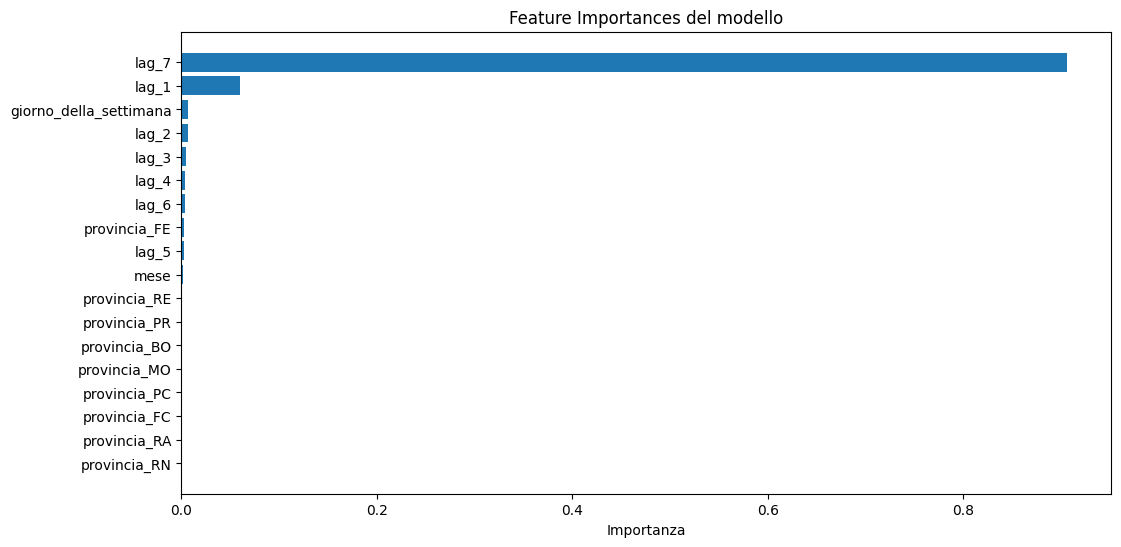

In [23]:
# ================================
# 10. Feature Importances del Modello
# ================================
importances = model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_columns, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

print("Feature Importances:")
print(feat_imp_df)

plt.figure(figsize=(12,6))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importanza')
plt.title('Feature Importances del modello')
plt.show()
